# Import bibliotek

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn_som.som import SOM


In [2]:
data_rfm = pd.read_parquet('df.parquet')
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

data_norm

,log_R,log_F,log_M
0,3.737670,5.209486,8.368925
1,4.356709,3.332205,7.271175
2,3.044522,4.290459,7.285198
3,5.746203,2.833213,5.688330
4,4.317488,4.510860,7.143941
...,...,...,...
4365,5.087596,2.397895,5.201806
4366,1.791759,2.079442,4.404522
4367,4.553877,2.639057,5.179534
4368,2.484907,6.629363,7.647729


# Dobór parametrów

In [3]:
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

data_rfm = pd.read_parquet('df.parquet')
data_norm = data_rfm[["log_R", "log_F", "log_M"]]
X = data_norm

# Podział danych na zbiory treningowe i testowe
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Convert pandas DataFrames to NumPy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Definicja zakresów parametrów do przeszukania
grid_params = {
    'grid_size': [1],
    'learning_rate': [0.5],
    'num_iterations': [10000]
}

# Funkcja oceny modelu
def evaluate_model(som, data, grid_size):
    labels_2d = np.array([som.winner(x) for x in data])
    labels_1d = labels_2d[:, 0] * grid_size + labels_2d[:, 1]
    return silhouette_score(data, labels_1d)

# Optymalizacja siatkowa
best_score = -1
best_params = None

for grid_size in grid_params['grid_size']:
    for learning_rate in grid_params['learning_rate']:
        for num_iterations in grid_params['num_iterations']:
            print(grid_size, learning_rate, num_iterations)
            som = MiniSom(1, 3, X_train.shape[1], sigma=learning_rate, learning_rate=0.5)
            som.train_random(X_train, num_iterations)

            score = evaluate_model(som, X_train, grid_size)

            if score > best_score:
                print("Best parameters:", best_params)
                print("Best score:", best_score)
                best_score = score
                best_params = {
                    'grid_size': grid_size,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations
                }

print("Best FINAL parameters:", best_params)
print("Best FINAL score:", best_score)

1 0.5 10000
Best parameters: None
Best score: -1
Best FINAL parameters: {'grid_size': 1, 'learning_rate': 0.5, 'num_iterations': 10000}
Best FINAL score: 0.30241198558602406


# Algorytm

In [4]:
from minisom import MiniSom

n_rows, n_cols = 1, 3
n_iterations = 100000

som = MiniSom(n_rows, n_cols, data_norm.shape[1], sigma=0.7, learning_rate=0.5)
som.train_batch(data_norm.values, n_iterations)

winner_coordinates = np.array([som.winner(x) for x in data_norm.values]).T
cluster_index = np.ravel_multi_index(winner_coordinates, (n_rows, n_cols))
data_rfm["Cluster"] = cluster_index

# Analiza wyników

In [5]:
sns.set_style("whitegrid")
data_rfm['Cluster'] = data_rfm['Cluster'].apply(str)

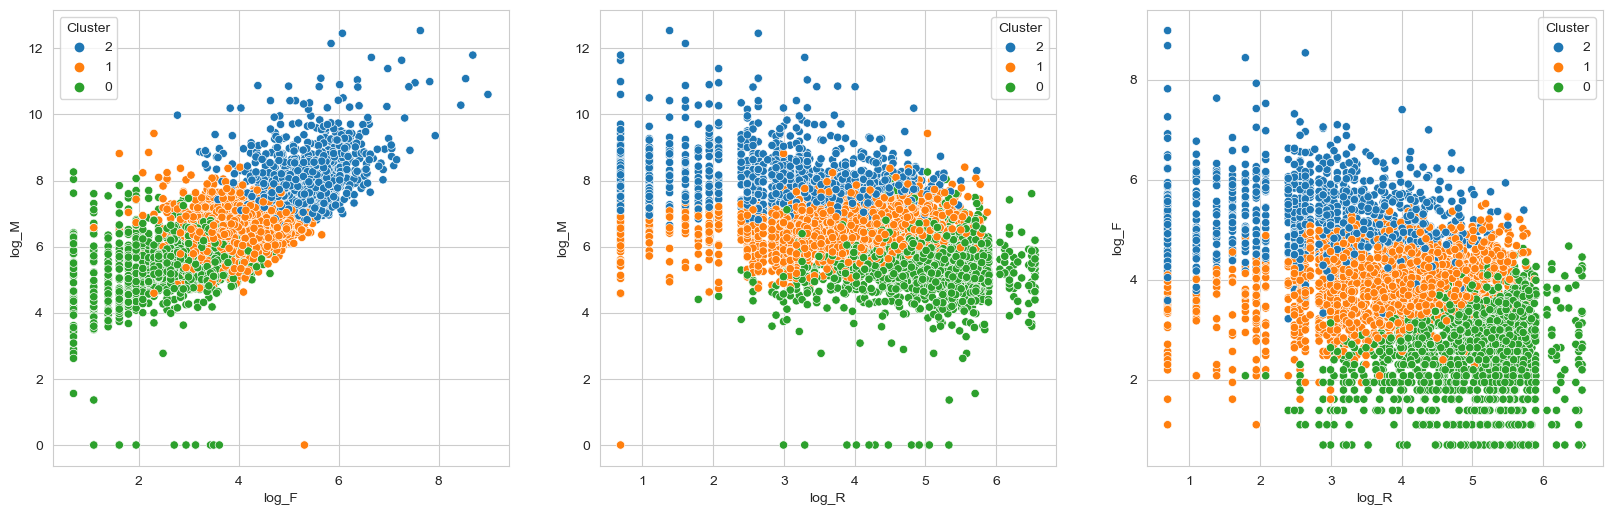

In [6]:
f, axes = plt.subplots(1, 3, subplot_kw=dict(box_aspect=1), figsize=(20, 20))

sns.scatterplot(data=data_rfm, x='log_F', y='log_M', hue='Cluster', ax=axes[0])
sns.scatterplot(data=data_rfm, x='log_R', y='log_M', hue='Cluster', ax=axes[1])
sns.scatterplot(data=data_rfm, x='log_R', y='log_F', hue='Cluster', ax=axes[2])


plt.show()

## Analiza biznesowa

In [7]:
df_table = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'})

df_result = data_rfm.groupby('Cluster').agg({'Cluster': 'count','R_score': 'mean', 'F_score': 'mean', 'M_score':'mean', 'RFM_Score':'mean'}).round(2)

df_result = df_result.rename_axis('Klaster').rename(columns={
    'Cluster': 'Liczba klientów',
    'R_score': 'Wartość R',
    'F_score': 'Wartość F',
    'M_score': 'Wartość M',
    'RFM_Score': 'Wartość RFM'
})

df_result

,Liczba klientów,Wartość R,Wartość F,Wartość M,Wartość RFM
Klaster,,,,,
0,1551,0.60,0.43,0.49,1.52
1,1720,1.81,1.67,1.60,5.07
2,1058,2.40,2.83,2.88,8.11


In [8]:
with open("csv_table.tex", 'w') as f:
    f.write(df_result.to_latex(index=True))

C:\Users\marce\AppData\Local\Temp\ipykernel_8416\191917624.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_result.to_latex(index=True))


In [9]:
def assign_label_Recency(value):
    print(value)
    if 0 < value <= 1:
        return 'Utracony'
    elif 1 < value <= 2:
        return 'Odchodzący'
    elif 2 < value <= 3:
        return 'Aktywny'


def assign_label_Frequency_or_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

def assign_label_Frequency_and_Monetary(value):
    if 0 < value <= 1:
        return 'Niska'
    elif 1 < value <= 2:
        return 'Średnia'
    elif 2 < value <= 3:
        return 'Wysoka'

df = df_table.copy()

df['Aktywność klienta'] = df['R_score'].apply(assign_label_Recency)
df['Częstotliwość zakupów'] = df['F_score'].apply(assign_label_Frequency_and_Monetary)
df['Wartość monetarna'] = df['M_score'].apply(assign_label_Frequency_and_Monetary)
df['Kategoria klientów R, F i M'] = df.apply(lambda row: f"{row['Aktywność klienta']}, {row['Częstotliwość zakupów']} częstotliwość, {row['Wartość monetarna']} wartość monetarna", axis=1)
# Definiowanie funkcji przypisującej etykiety na podstawie wartości z kolumny 2 i Avg_FM
def assign_label_R_vs_FM(row):
    print(row)
    r_value = row['R_score']
    fm_value = (row['F_score'] + row['M_score']) / 2

    if 2 < r_value <= 3:
        if 2 < fm_value <= 3:
            fm_label = 'Czempioni'
        elif 1 < fm_value <= 2:
            fm_label = 'Obiecujący'
        elif 0 < fm_value <= 1:
            fm_label = 'Nowi klienci'

    elif 1 < r_value <= 2:
        if 2 < fm_value <= 3:
            fm_label = 'Lojalni klienci'
        elif 1 < fm_value <= 2:
            fm_label = 'Wymagają uwagi'
        elif 0 < fm_value <= 1:
            fm_label = 'Powinno się skontaktować'

    elif 0 < r_value <= 1:
        if 2 < fm_value <= 3:
            fm_label = 'Nie powinno się stracić'
        elif 1 < fm_value <= 2:
            fm_label = 'Odchodzący'
        elif 0 < fm_value <= 1:
            fm_label = 'Utraceni'

    return fm_label

df['Kategoria klientów R vs FM'] = df.apply(lambda row : assign_label_R_vs_FM(row), axis=1)

df = df.drop(columns=['RFM_Score', 'R_score', 'F_score', 'M_score'])
print(df)

0.5957446808510638
1.8116279069767443
2.4017013232514177
Cluster                                                                     1551
R_score                                                                 0.595745
F_score                                                                 0.431335
M_score                                                                 0.491296
RFM_Score                                                               1.518375
Aktywność klienta                                                       Utracony
Częstotliwość zakupów                                                      Niska
Wartość monetarna                                                          Niska
Kategoria klientów R, F i M    Utracony, Niska częstotliwość, Niska wartość m...
Name: 0, dtype: object
Cluster                                                                     1720
R_score                                                                 1.811628
F_score                      

## Analiza klastrów

In [10]:
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from validclust import dunn
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances

print(f'Wskaznik sylwetki: {silhouette_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks CH: {calinski_harabasz_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks DB: {davies_bouldin_score(data_norm, data_rfm["Cluster"]).round(2)}')
print(f'Indeks Dunn: {dunn(pairwise_distances(data_norm, metric="cityblock"), data_rfm["Cluster"]).round(5)}')


Wskaznik sylwetki: 0.29
Indeks CH: 2950.22
Indeks DB: 1.16
Indeks Dunn: 0.0044


# Analiza algorytmu

In [11]:
import pandas as pd
from scipy.spatial.distance import euclidean
import sys

def intra_cluster_distance(cluster_points):
    distances = []
    for i in range(len(cluster_points)):
        for j in range(i+1, len(cluster_points)):
            distances.append(euclidean(cluster_points[i], cluster_points[j]))
    return max(distances) if distances else 0

def inter_cluster_distance(c1_points, c2_points):
    distances = []
    for point1 in c1_points:
        for point2 in c2_points:
            distances.append(euclidean(point1, point2))
    return min(distances) if distances else sys.maxsize

def dunn_index(data_norm, data_clusters):
    clusters = data_clusters.unique()
    clustered_points = {cluster: data_norm[data_clusters == cluster].values.tolist() for cluster in clusters}
    max_intra_cluster_dist = max([intra_cluster_distance(cluster_points) for cluster_points in clustered_points.values()])

    min_inter_cluster_dist = sys.maxsize
    for i, cluster1 in enumerate(clusters[:-1]):
        for cluster2 in clusters[i+1:]:
            dist = inter_cluster_distance(clustered_points[cluster1], clustered_points[cluster2])
            min_inter_cluster_dist = min(min_inter_cluster_dist, dist)

    return min_inter_cluster_dist / max_intra_cluster_dist

# Read data_norm from CSV or create a pandas DataFrame with three columns for coordinates
# data_norm = pd.read_csv('data_norm.csv')
# data_rfm = pd.read_csv('data_rfm.csv')

# Example: Creating a pandas DataFrame for demonstration purposes


# Calculate Dunn Index
result = dunn_index(data_norm, data_rfm['Cluster'])

print(f'Dunn Index: {result}')

Dunn Index: 0.005109487357639809
